In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import split_sequence, get_apple_close_price, plot_series

In [2]:
apple_close_price = get_apple_close_price()

In [3]:
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [4]:
train, test = train_test_split(apple_close_price, 
                               test_size=0.05, 
                               shuffle=False)

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
scaler = MinMaxScaler()

In [7]:
scaled_train = scaler.fit_transform(train.values.reshape(-1, 1))
scaled_test = scaler.transform(test.values.reshape(-1, 1))

In [8]:
# Core layers
from keras.layers \
    import Activation, Dropout, Flatten, Dense, Input, LeakyReLU, Reshape

# Recurrent layers
from keras.layers import LSTM

# Convolutional layers
from keras.layers import Conv1D, MaxPooling1D

# Normalization layers
from keras.layers import BatchNormalization

# Merge layers
from keras.layers import concatenate

# Layer wrappers
from keras.layers import Bidirectional, TimeDistributed

# Keras models
from keras.models import Model, Sequential

# Keras optimizers
from keras.optimizers import Adam, RMSprop

import keras.backend as K

import warnings
warnings.simplefilter('ignore')

Using TensorFlow backend.


In [9]:
look_back = 3
n_features = 1

In [10]:
X_train, y_train = split_sequence(scaled_train, look_back)
X_test, y_test = split_sequence(scaled_test, look_back)

In [168]:
def build_generator_net(look_back, n_features):
    net = Sequential()

    net.add(LSTM(50, input_shape=(look_back, n_features)))
    net.add(LeakyReLU(alpha=0.2))
    net.add(Dense(n_features))

    print('Generator summary:')
    net.summary()
    
    return net

In [169]:
def build_discriminator_net(look_back, n_features):
    net = Sequential()

    net.add(Conv1D(64, kernel_size=2, input_shape=(look_back + 1, n_features))) # +1 => +target
    net.add(LeakyReLU(alpha=0.2))
    net.add(Flatten())
    net.add(Dense(1, activation='sigmoid'))

    print('Discriminator summary:')
    net.summary()
    
    return net

In [170]:
def build_discriminator_model(look_back, n_features, optimizer=Adam()):
    dis_net = build_discriminator_net(look_back, n_features)
    
    net = Sequential()
    net.add(dis_net)
    
    seq = Input((look_back + 1, n_features))
    valid = net(seq)
    
    model = Model(seq, valid)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model, dis_net

In [171]:
def build_adversarial_model(look_back, n_features, dm_optimizer=Adam(), am_optimizer=Adam()):
    
    dis_model, dis_net = build_discriminator_model(look_back, n_features, optimizer=dm_optimizer)
    
    gen_net = build_generator_net(look_back, n_features)
    
    net = Sequential()
    net.add(gen_net)
    
    gen_input = Input((look_back, n_features))
    gen_output = net(gen_input)
    gen_output = Reshape((1, 1))(gen_output)
    gen_output_plus_pred = concatenate([gen_input, gen_output], axis=1)
    
    dis_net.trainable = False
    valid = dis_net(gen_output_plus_pred)
    
    model = Model(gen_input, valid)
    model.compile(loss='binary_crossentropy', optimizer=am_optimizer, metrics=['accuracy'])
    
    print('Adversarial summary:')
    model.summary()
    
    return model, dis_model, dis_net, gen_net
    

In [172]:
adv_model, dis_model, dis_net, gen_net = build_adversarial_model(look_back, 
                                                                 n_features, 
                                                                 dm_optimizer=Adam(lr=0.01), 
                                                                 am_optimizer=Adam(lr=0.0001))

Discriminator summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 3, 64)             192       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 3, 64)             0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 192)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 193       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
Generator summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 50)                10400     
____________________________________

In [173]:
def get_batch(X, y, batch_idx, batch_size):
    X_batch = X[batch_idx:batch_idx+batch_size]
    y_batch = y[batch_idx:batch_idx+batch_size]
    
    return X_batch, y_batch

In [174]:
def get_real_and_fake_samples(X, y, generator):
    X_real = np.concatenate((X, y.reshape(-1, 1, 1)), axis=1)  
    y_pred = generator.predict(X)  
    X_fake = np.concatenate((X, y_pred.reshape(-1, 1, 1)), axis=1)
    
    return X_real, X_fake

In [175]:
def train_GAN(X, y, adv_model, dis_model, gen_net, n_epochs=100, batch_size=100, look_back=3, n_features=1):
    data_len = len(X)
    stop = data_len - batch_size
    n_points = look_back + 1 # look back + prediction

    hist_d_loss_real = []
    hist_d_loss_fake = []
    hist_d_loss = []
    hist_g_loss = []
    
    for epoch in range(n_epochs):

        for batch_idx in range(0, stop, batch_size):
            
            X_batch, y_batch = get_batch(X, y, batch_idx, batch_size)
            X_real, X_fake = get_real_and_fake_samples(X_batch, y_batch, gen_net)
            
            y_real = np.ones((batch_size, 1))
            y_fake = np.zeros((batch_size, 1))
            
            # Train discriminator
            d_loss_real = dis_model.train_on_batch(X_real, y_real)
            d_loss_fake = dis_model.train_on_batch(X_fake, y_fake)
            d_loss = np.add(d_loss_real, d_loss_fake) / 2
            
            # Train generator
            g_loss = adv_model.train_on_batch(X_batch, y_real)
            
        print ("Epoch %d/%d [D loss: %f] [G loss: %f]" % (epoch+1, n_epochs, d_loss[0], g_loss[0]))
        
        rnd_idx = np.random.randint(0, len(X_real))
        
        print('Real example: ', X_real[rnd_idx].reshape(-1,))
        print('Fake example: ', X_fake[rnd_idx].reshape(-1,))
        
        hist_d_loss_real.append(d_loss_real)
        hist_d_loss_fake.append(d_loss_fake)
        hist_d_loss.append(d_loss)
        hist_g_loss.append(g_loss)
        
    return hist_d_loss_real, hist_d_loss_fake, hist_d_loss, hist_g_loss


In [176]:
hist_d_loss_real, hist_d_loss_fake, hist_d_loss, hist_g_loss = \
    train_GAN(X_train, y_train, adv_model, dis_model, gen_net, n_epochs=100, batch_size=32)

Epoch 1/100 [D loss: 0.000052] [G loss: 9.240411]
Real example:  [0.90109263 0.91238172 0.91129131 0.92007876]
Fake example:  [0.91815448 0.91706407 0.90718622 0.16557086]
Epoch 2/100 [D loss: 0.000150] [G loss: 8.248308]
Real example:  [0.91706407 0.90718622 0.90827662 0.90346595]
Fake example:  [0.98178354 0.98620937 1.         0.205851  ]
Epoch 3/100 [D loss: 0.000167] [G loss: 8.141008]
Real example:  [1.         0.99743425 0.99595901 0.96247677]
Fake example:  [0.91815448 0.91706407 0.90718622 0.44924173]
Epoch 4/100 [D loss: 0.001026] [G loss: 6.560192]
Real example:  [0.98178354 0.98620937 1.         0.99743425]
Fake example:  [0.92020708 0.91815448 0.91706407 0.48675752]
Epoch 5/100 [D loss: 3.497161] [G loss: 0.078515]
Real example:  [0.92007876 0.92578742 0.92033529 0.92104086]
Fake example:  [0.90827662 0.90346595 0.90846904 1.04403782]
Epoch 6/100 [D loss: 1.801180] [G loss: 0.255229]
Real example:  [0.93861586 0.95420247 0.98017999 0.98646599]
Fake example:  [0.90827662 0.

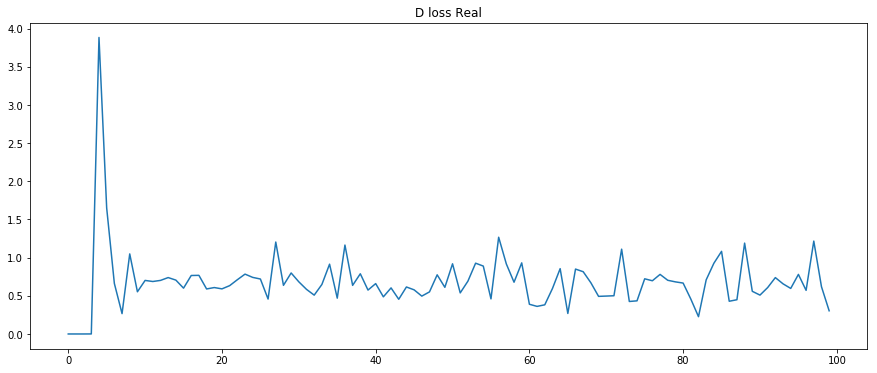

In [177]:
plot_series(list(map(lambda v: v[0], hist_d_loss_real)), title='D loss Real')

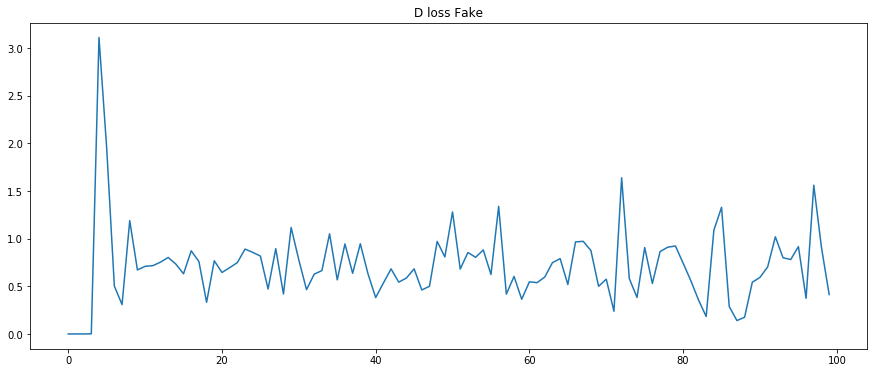

In [178]:
plot_series(list(map(lambda v: v[0], hist_d_loss_fake)), title='D loss Fake')

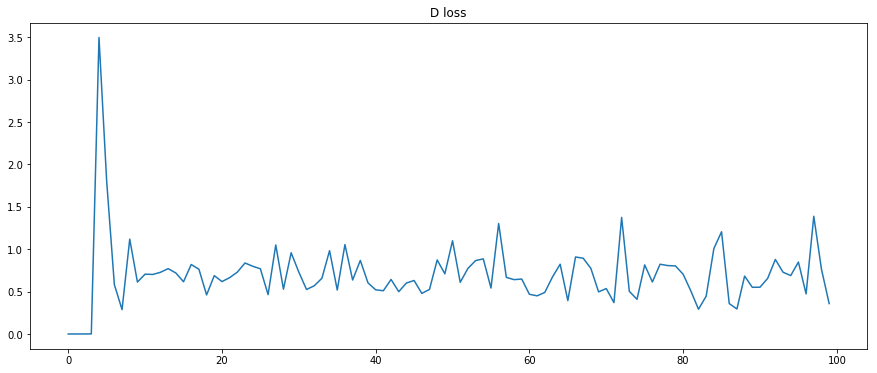

In [179]:
plot_series(list(map(lambda v: v[0], hist_d_loss)), title='D loss')

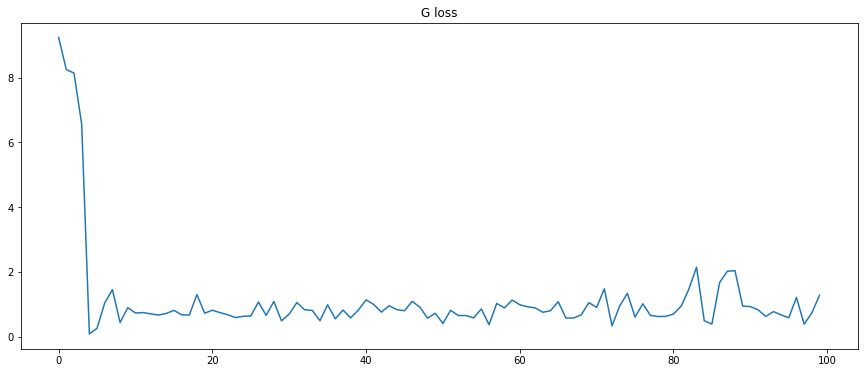

In [180]:
plot_series(list(map(lambda v: v[0], hist_g_loss)), title='G loss')

In [188]:
X_real = np.concatenate((X_test[2], y_test[2].reshape(-1, 1)))
dis_model.predict(X_real.reshape(-1, 4, 1)).item(0) >= 0.5

True

In [189]:
pred = gen_net.predict(X_test[2].reshape(-1, 3, 1))
X_fake = np.concatenate((X_test[2], pred.reshape(-1, 1)))
dis_model.predict(X_fake.reshape(-1, 4, 1)).item(0) >= 0.5

False

In [190]:
X_fake

array([[0.92033529],
       [0.9225162 ],
       [0.91918078],
       [0.96894062]])

In [121]:
get_batch(X_test, y_test, 286, 100)

(array([[[1.34726592],
         [1.36702173],
         [1.39434628]],
 
        [[1.36702173],
         [1.39434628],
         [1.38074817]],
 
        [[1.39434628],
         [1.38074817],
         [1.3780541 ]],
 
        [[1.38074817],
         [1.3780541 ],
         [1.37811831]],
 
        [[1.3780541 ],
         [1.37811831],
         [1.38094058]],
 
        [[1.37811831],
         [1.38094058],
         [1.3852381 ]],
 
        [[1.38094058],
         [1.3852381 ],
         [1.3966554 ]],
 
        [[1.3852381 ],
         [1.3966554 ],
         [1.4079444 ]],
 
        [[1.3966554 ],
         [1.4079444 ],
         [1.42898304]],
 
        [[1.4079444 ],
         [1.42898304],
         [1.44213221]],
 
        [[1.42898304],
         [1.44213221],
         [1.45880922]],
 
        [[1.44213221],
         [1.45880922],
         [1.46349158]],
 
        [[1.45880922],
         [1.46349158],
         [1.45393435]],
 
        [[1.46349158],
         [1.45393435],
         [1.429752